In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3,
                            methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[sub_df["method"].isin(methods)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(parameter_table)
    

In [3]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full", "Seperated", "Pyramid"], 
                            latent_dimension=2, item_dimension=20,
                             aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df = df[(df["item_dimension"] == item_dimension) & (df["latent_dimension"] == latent_dimension)]
        q_df_early = df[["early_l_estimated", "method", "sample_size"]]
        
        q_df_early.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_early.loc[:,"Model"] = "Early"
        q_df_late = df[["late_l_estimated", "method", "sample_size"]]
        q_df_late.columns = ["Marginal Log-Likelihood", "Method", "N"]
        q_df_late.loc[:,"Model"] = "Late"
        q_df = pd.concat((q_df_early, q_df_late), axis=0)
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    combined_df = combined_df.replace(method_replacement_dict)
    combined_df = np.round(combined_df, 0)
    fit_table = pd.crosstab(index=[combined_df["N"], combined_df["Method"]], 
                            columns=[combined_df["Model"], combined_df["Q-type"]],
                            values=combined_df["Marginal Log-Likelihood"],
                            aggfunc=aggfunc)
    n = np.min(combined_df.groupby(["Model", "Q-type", "N"])["Method"].value_counts())
    print(fit_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", $n={0}$".format(n), 
                                   position="H", escape=False))
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [4]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption="",
                        methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    df = df[df["method"].isin(methods)]
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    df = df.rename(columns={"method": "Method", "latent_dimension": "Latent Dimension", "item_dimension": "Item Dimension", "sample_size": "N"})
    table = pd.crosstab(index=[df["N"], df["Method"]],
                columns=[df["Latent Dimension"], df["Item Dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, multicolumn=True,
                             caption=caption+", $n={0}$".format(n),
                             position="H"))
    return(table)

In [5]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+" n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

In [6]:
full_Q_df = pd.read_csv("results/full_q.csv")
print("Full Q sample size: {0}".format(full_Q_df.shape[0]))
sep_Q_df = pd.read_csv("results/seperated_q.csv")
print("Seperated Q sample size: {0}".format(sep_Q_df.shape[0]))
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
print("Pyramid Q sample size: {0}".format(pyramid_Q_df.shape[0]))

Full Q sample size: 5382
Seperated Q sample size: 5370
Pyramid Q sample size: 4296


## Simulatuion Results

### Model Fit

In [7]:
single_metric_table(full_Q_df, metric="late_l_estimated")

\begin{table}[H]
\centering
\caption{, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &        10 &        20 &        30 &        10 &        20 &        30 \\
\textbf{N} & \textbf{Method} &           &           &           &           &           &           \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  -187.320 &  -288.170 &  -407.870 &  -215.550 &  -317.155 &  -427.490 \\
    & \textbf{Initial Parameters} &  -235.530 &  -387.590 &  -534.585 &  -289.075 &  -457.485 &  -623.155 \\
    & \textbf{Late EM} &  -182.100 &  -288.505 &  -403.170 &  -199.845 &  -311.200 &  -428.935 \\
    & \textbf{Pure Competency} &  -184.185 &  -288.870 &  -402.115 &  -209.280 &  -310.125 &  -424.685 \\
    & \textbf{Real early Param.} &  -191.045 &  -294.690 &  -407.850 &  -223.550 &  -317.295 &  -426.900 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  -6

Latent Dimension               2                             3            \
Item Dimension                10        20        30        10        20   
N   Method                                                                 
30  Difference          -187.320  -288.170  -407.870  -215.550  -317.155   
    Initial Parameters  -235.530  -387.590  -534.585  -289.075  -457.485   
    Late EM             -182.100  -288.505  -403.170  -199.845  -311.200   
    Pure Competency     -184.185  -288.870  -402.115  -209.280  -310.125   
    Real early Param.   -191.045  -294.690  -407.850  -223.550  -317.295   
100 Difference          -679.595 -1065.785 -1508.335  -725.440 -1116.845   
    Initial Parameters  -845.340 -1339.325 -1907.005  -939.965 -1574.530   
    Late EM             -656.075 -1049.065 -1511.210  -699.775 -1107.840   
    Pure Competency     -661.640 -1057.640 -1519.495  -729.010 -1114.200   
    Real early Param.   -672.105 -1059.605 -1496.595  -766.530 -1129.925   
200 Difference         -1292.195 -2120.075 -2979.585 -1498.205 -2279.810   
    Initial Parameters -1567.835 -2656.475 -3667.025 -1982.505 -3100.400   
    Late EM            -1257.835 -2060.075 -2944.765 -1443.315 -2213.350   
    Pure Competency    -1299.145 -2053.770 -2959.360 -1512.500 -2239.805   
    Real early Param.  -1339.305 -2068.165 -2969.645 -1586.315 -2305.015   

Latent Dimension                  
Item Dimension                30  
N   Method                        
30  Difference          -427.490  
    Initial Parameters  -623.155  
    Late EM             -428.935  
    Pure Competency     -424.685  
    Real early Param.   -426.900  
100 Difference         -1557.365  
    Initial Parameters -2057.795  
    Late EM            -1508.345  
    Pure Competency    -1522.660  
    Real early Param.  -1516.230  
200 Difference         -3164.350  
    Initial Parameters -4371.810  
    Late EM            -3056.210  
    Pure Competency    -3076.840  
    Real early Param.  -3117.610

In [8]:
likelihood_table_model(df_list=[full_Q_df, sep_Q_df, pyramid_Q_df], caption="Median Marginal Log-Likelihood, $D=2$, $J=20$")

\begin{table}[H]
\centering
\caption{Median Marginal Log-Likelihood, $D=2$, $J=20$, $n=44$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Model} & \multicolumn{3}{l}{Early} & \multicolumn{3}{l}{Late} \\
    & \textbf{Q-type} &    Full & Pyramid & Seperated &    Full & Pyramid & Seperated \\
\textbf{N} & \textbf{Method} &         &         &           &         &         &           \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  -282.5 &  -283.0 &    -313.0 &  -288.0 &  -283.0 &    -323.5 \\
    & \textbf{Initial Parameters} &  -310.0 &  -310.0 &    -332.0 &  -387.5 &  -355.0 &    -424.5 \\
    & \textbf{Late EM} &  -282.5 &  -284.0 &    -312.5 &  -288.5 &  -288.0 &    -316.0 \\
    & \textbf{Pure Competency} &  -285.5 &  -284.0 &    -313.0 &  -289.0 &  -281.0 &    -319.0 \\
    & \textbf{Real Param.} &  -312.0 &  -313.0 &    -337.0 &  -319.0 &  -312.0 &    -337.0 \\
    & \textbf{Real early Param.} &     NaN &     NaN &       NaN &  -294.5 &  -288.0 &    -322.5 \

Model                    Early                      Late                  
Q-type                    Full Pyramid Seperated    Full Pyramid Seperated
N   Method                                                                
30  Difference          -282.5  -283.0    -313.0  -288.0  -283.0    -323.5
    Initial Parameters  -310.0  -310.0    -332.0  -387.5  -355.0    -424.5
    Late EM             -282.5  -284.0    -312.5  -288.5  -288.0    -316.0
    Pure Competency     -285.5  -284.0    -313.0  -289.0  -281.0    -319.0
    Real Param.         -312.0  -313.0    -337.0  -319.0  -312.0    -337.0
    Real early Param.      NaN     NaN       NaN  -294.5  -288.0    -322.5
100 Difference         -1011.5 -1002.5   -1088.5 -1065.5 -1036.5   -1158.5
    Initial Parameters -1058.5 -1044.5   -1122.5 -1339.5 -1264.5   -1482.0
    Late EM            -1011.5 -1001.5   -1089.5 -1049.0 -1015.0   -1128.0
    Pure Competency    -1014.5 -1002.5   -1095.0 -1058.0 -1032.0   -1120.0
    Real Param.        -1048.5 -1027.0   -1127.0 -1081.5 -1058.5   -1160.5
    Real early Param.      NaN     NaN       NaN -1059.5 -1049.0   -1133.5
200 Difference         -2097.0 -2006.5   -2200.0 -2120.0 -2006.5   -2361.5
    Initial Parameters -2161.0 -2079.5   -2264.5 -2656.5 -2399.5   -3054.5
    Late EM            -2096.0 -2005.0   -2200.0 -2060.0 -1994.5   -2331.0
    Pure Competency    -2103.0 -2005.0   -2215.5 -2053.5 -2032.5   -2336.5
    Real Param.        -2153.5 -2034.0   -2226.0 -2116.5 -2064.5   -2382.5
    Real early Param.      NaN     NaN       NaN -2068.0 -2064.0   -2362.0

### Full Q Matrix

In [9]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix Parameter estimation median RMSE, $J=20$, $D=2$")

\begin{table}[H]
\centering
\caption{Full Q-Matrix Parameter estimation median RMSE, $J=20$, $D=2$, $n=50$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.642 &       1.322 &       0.066 &  2.737 &       2.753 &       0.216 &   0.257 \\
    & \textbf{Initial Parameters} &  0.615 &       0.548 &       0.148 &  0.829 &       1.492 &       0.444 &   0.360 \\
    & \textbf{Late EM} &  1.598 &       1.351 &       0.065 &  4.655 &       4.171 &       0.225 &   0.317 \\
    & \textbf{Pure Competency} &  1.577 &       1.331 &       0.206 &  4.874 &       3.874 &       0.243 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.175 &       3.422 &       0.175 &   0.332 \\
\c

$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.642       1.322       0.066  2.737   
            Initial Parameters  0.615       0.548       0.148  0.829   
            Late EM             1.598       1.351       0.065  4.655   
            Pure Competency     1.577       1.331       0.206  4.874   
            Real early Param.     NaN         NaN         NaN  4.175   
100         Difference          0.465       0.393       0.055  0.555   
            Initial Parameters  0.662       0.435       0.156  0.857   
            Late EM             0.440       0.394       0.058  0.730   
            Pure Competency     0.438       0.386       0.198  0.672   
            Real early Param.     NaN         NaN         NaN  0.575   
200         Difference          0.320       0.250       0.067  0.421   
            Initial Parameters  0.627       0.387       0.156  0.878   
            Late EM             0.325       0.256       0.065  0.467   
            Pure Competency     0.325       0.257       0.198  0.440   
            Real early Param.     NaN         NaN         NaN  0.454   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.753       0.216   0.257  
            Initial Parameters       1.492       0.444   0.360  
            Late EM                  4.171       0.225   0.317  
            Pure Competency          3.874       0.243   0.277  
            Real early Param.        3.422       0.175   0.332  
100         Difference               0.691       0.151   0.218  
            Initial Parameters       1.405       0.388   0.351  
            Late EM                  0.781       0.186   0.306  
            Pure Competency          1.026       0.266   0.283  
            Real early Param.        0.721       0.182   0.284  
200         Difference               0.474       0.115   0.208  
            Initial Parameters       1.451       0.387   0.335  
            Late EM                  0.590       0.205   0.296  
            Pure Competency          0.693       0.275   0.260  
            Real early Param.        0.556       0.161   0.285

In [10]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.314 &  0.257 &  0.246 &  0.318 &  0.287 &  0.264 \\
    & \textbf{Initial Parameters} &  0.341 &  0.360 &  0.343 &  0.336 &  0.324 &  0.318 \\
    & \textbf{Late EM} &  0.286 &  0.317 &  0.275 &  0.320 &  0.333 &  0.343 \\
    & \textbf{Pure Competency} &  0.261 &  0.277 &  0.283 &  0.279 &  0.283 &  0.300 \\
    & \textbf{Real early Param.} &  0.309 &  0.332 &  0.302 &  0.345 &  0.355 &  0.357 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.278 &  0.218 &  0.166 &  0.294 &  0.233 &  0.219 \\
    & \textbf{Initial Parameters} &  0.332 &  

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.314  0.257  0.246  0.318  0.287  0.264
    Initial Parameters  0.341  0.360  0.343  0.336  0.324  0.318
    Late EM             0.286  0.317  0.275  0.320  0.333  0.343
    Pure Competency     0.261  0.277  0.283  0.279  0.283  0.300
    Real early Param.   0.309  0.332  0.302  0.345  0.355  0.357
100 Difference          0.278  0.218  0.166  0.294  0.233  0.219
    Initial Parameters  0.332  0.351  0.333  0.324  0.316  0.329
    Late EM             0.286  0.306  0.283  0.306  0.317  0.325
    Pure Competency     0.295  0.283  0.262  0.290  0.290  0.292
    Real early Param.   0.294  0.284  0.294  0.320  0.331  0.333
200 Difference          0.270  0.208  0.166  0.277  0.236  0.199
    Initial Parameters  0.335  0.335  0.338  0.324  0.329  0.354
    Late EM             0.305  0.296  0.355  0.318  0.332  0.320
    Pure Competency     0.269  0.260  0.270  0.291  0.289  0.322
    Real early Param.   0.308  0.285  0.340  0.350  0.348  0.341

In [11]:
single_metric_table(full_Q_df, "rmse_late_sigma", caption="Median RMSE for $\Sigma^l$")

\begin{table}[H]
\centering
\caption{Median RMSE for $\Sigma^l$, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.214 &  0.216 &  0.227 &  0.255 &  0.230 &  0.227 \\
    & \textbf{Initial Parameters} &  0.376 &  0.444 &  0.449 &  0.393 &  0.424 &  0.424 \\
    & \textbf{Late EM} &  0.246 &  0.225 &  0.211 &  0.262 &  0.248 &  0.256 \\
    & \textbf{Pure Competency} &  0.243 &  0.243 &  0.238 &  0.295 &  0.298 &  0.311 \\
    & \textbf{Real early Param.} &  0.209 &  0.175 &  0.166 &  0.234 &  0.219 &  0.244 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.158 &  0.151 &  0.163 &  0.211 &  0.168 &  0.184 \\
    & \textbf{Initial Parameters} &  0.360 &  0.

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.214  0.216  0.227  0.255  0.230  0.227
    Initial Parameters  0.376  0.444  0.449  0.393  0.424  0.424
    Late EM             0.246  0.225  0.211  0.262  0.248  0.256
    Pure Competency     0.243  0.243  0.238  0.295  0.298  0.311
    Real early Param.   0.209  0.175  0.166  0.234  0.219  0.244
100 Difference          0.158  0.151  0.163  0.211  0.168  0.184
    Initial Parameters  0.360  0.388  0.304  0.377  0.344  0.400
    Late EM             0.210  0.186  0.192  0.272  0.247  0.258
    Pure Competency     0.230  0.266  0.247  0.299  0.295  0.335
    Real early Param.   0.141  0.182  0.175  0.217  0.206  0.250
200 Difference          0.154  0.115  0.150  0.231  0.153  0.144
    Initial Parameters  0.376  0.387  0.377  0.397  0.378  0.371
    Late EM             0.240  0.205  0.176  0.297  0.238  0.258
    Pure Competency     0.268  0.275  0.237  0.346  0.283  0.301
    Real early Param.   0.164  0.161  0.150  0.250  0.213  0.239

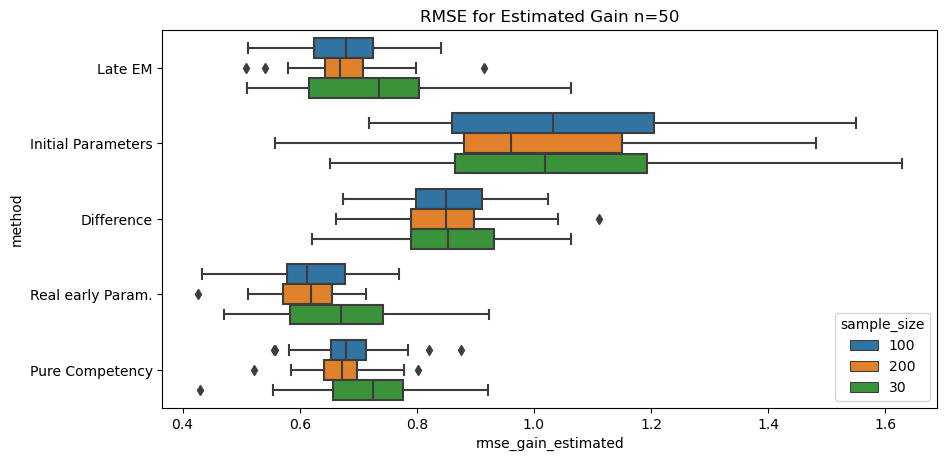

In [12]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

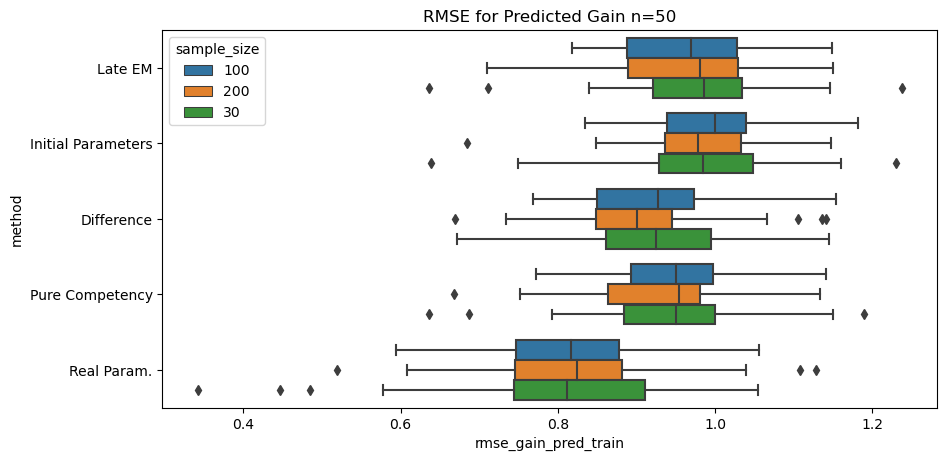

In [13]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Predicted Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [14]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, $n=50$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.893 &       0.898 &       0.092 &  1.402 &       1.517 &       0.196 &   0.250 \\
    & \textbf{Initial Parameters} &  0.491 &       0.506 &       0.185 &  0.898 &       1.278 &       0.425 &   0.342 \\
    & \textbf{Late EM} &  0.876 &       0.872 &       0.100 &  2.039 &       1.937 &       0.188 &   0.355 \\
    & \textbf{Pure Competency} &  0.943 &       0.884 &       0.168 &  2.139 &       2.066 &       0.259 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  1.781 &       1.921 &       0.171 &   0.369 \\
\cline{1-9}
\multirow{5}{*}{

$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          0.893       0.898       0.092  1.402   
            Initial Parameters  0.491       0.506       0.185  0.898   
            Late EM             0.876       0.872       0.100  2.039   
            Pure Competency     0.943       0.884       0.168  2.139   
            Real early Param.     NaN         NaN         NaN  1.781   
100         Difference          0.343       0.381       0.056  0.349   
            Initial Parameters  0.491       0.371       0.113  0.872   
            Late EM             0.327       0.385       0.055  0.401   
            Pure Competency     0.322       0.363       0.241  0.392   
            Real early Param.     NaN         NaN         NaN  0.386   
200         Difference          0.230       0.232       0.043  0.265   
            Initial Parameters  0.525       0.325       0.148  0.873   
            Late EM             0.227       0.227       0.042  0.285   
            Pure Competency     0.233       0.225       0.206  0.270   
            Real early Param.     NaN         NaN         NaN  0.259   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               1.517       0.196   0.250  
            Initial Parameters       1.278       0.425   0.342  
            Late EM                  1.937       0.188   0.355  
            Pure Competency          2.066       0.259   0.277  
            Real early Param.        1.921       0.171   0.369  
100         Difference               0.510       0.138   0.193  
            Initial Parameters       1.252       0.383   0.331  
            Late EM                  0.706       0.198   0.323  
            Pure Competency          0.780       0.260   0.250  
            Real early Param.        0.631       0.179   0.322  
200         Difference               0.305       0.142   0.218  
            Initial Parameters       1.202       0.364   0.340  
            Late EM                  0.724       0.201   0.298  
            Pure Competency          0.697       0.221   0.303  
            Real early Param.        0.543       0.181   0.296

In [15]:
single_metric_table(sep_Q_df, "rmse_psi", caption="Seperated Q-Matrix RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix RMSE for Correlations $\Psi$, $n=46$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.295 &  0.250 &  0.210 &  0.317 &  0.265 &  0.231 \\
    & \textbf{Initial Parameters} &  0.322 &  0.342 &  0.364 &  0.307 &  0.338 &  0.314 \\
    & \textbf{Late EM} &  0.285 &  0.355 &  0.308 &  0.310 &  0.355 &  0.352 \\
    & \textbf{Pure Competency} &  0.242 &  0.277 &  0.288 &  0.275 &  0.294 &  0.284 \\
    & \textbf{Real early Param.} &  0.265 &  0.369 &  0.292 &  0.331 &  0.359 &  0.359 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.244 &  0.193 &  0.162 &  0.300 &  0.227 &  0.193 \\
    & \textbf{Initial Param

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.295  0.250  0.210  0.317  0.265  0.231
    Initial Parameters  0.322  0.342  0.364  0.307  0.338  0.314
    Late EM             0.285  0.355  0.308  0.310  0.355  0.352
    Pure Competency     0.242  0.277  0.288  0.275  0.294  0.284
    Real early Param.   0.265  0.369  0.292  0.331  0.359  0.359
100 Difference          0.244  0.193  0.162  0.300  0.227  0.193
    Initial Parameters  0.327  0.331  0.357  0.337  0.352  0.336
    Late EM             0.299  0.323  0.295  0.316  0.324  0.358
    Pure Competency     0.252  0.250  0.262  0.308  0.313  0.309
    Real early Param.   0.300  0.322  0.302  0.357  0.365  0.350
200 Difference          0.299  0.218  0.151  0.290  0.221  0.181
    Initial Parameters  0.375  0.340  0.352  0.321  0.336  0.331
    Late EM             0.321  0.298  0.290  0.317  0.319  0.363
    Pure Competency     0.304  0.303  0.291  0.291  0.284  0.301
    Real early Param.   0.327  0.296  0.301  0.333  0.341  0.367

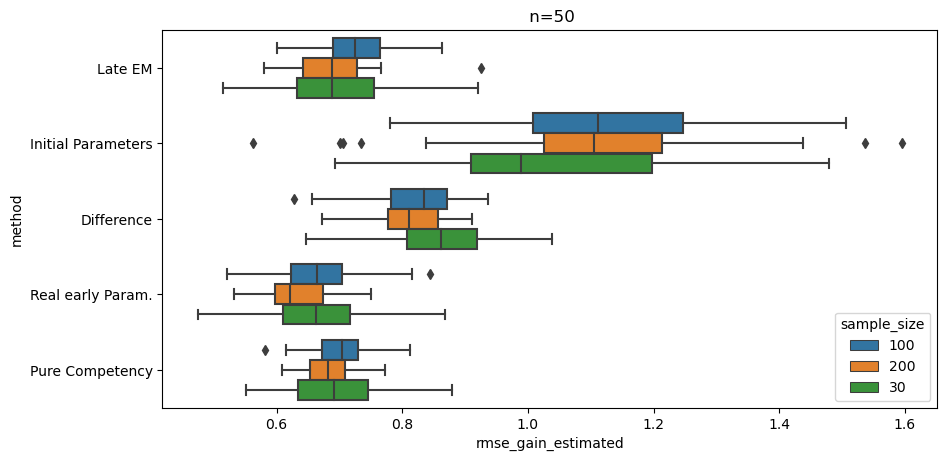

In [16]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

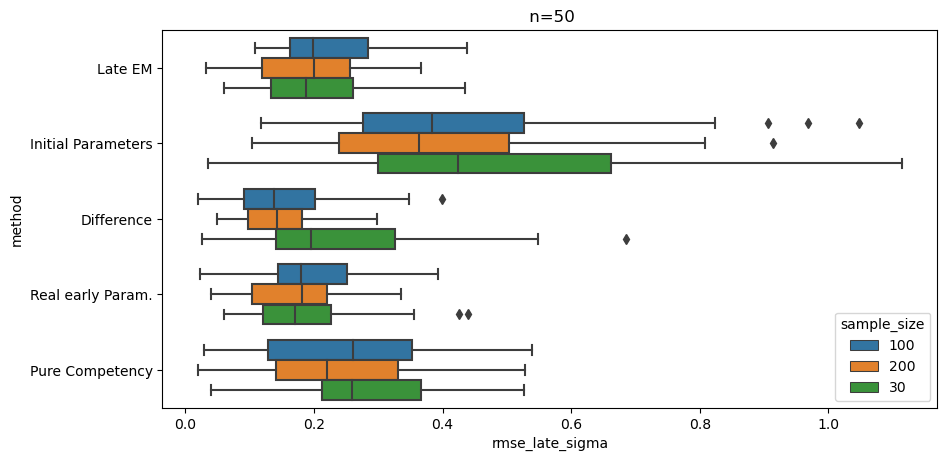

In [17]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

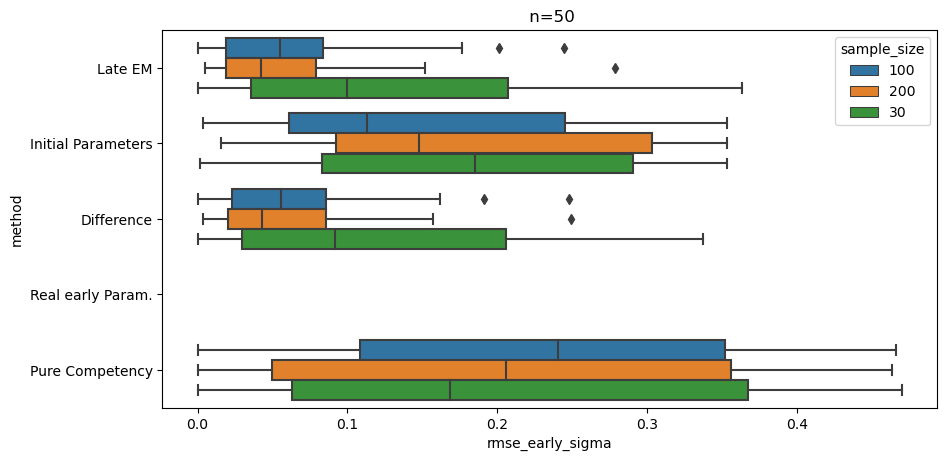

In [18]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [19]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, $n=50$}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.642 &       1.322 &       0.066 &  2.737 &       2.753 &       0.216 &   0.257 \\
    & \textbf{Initial Parameters} &  0.615 &       0.548 &       0.148 &  0.829 &       1.492 &       0.444 &   0.360 \\
    & \textbf{Late EM} &  1.598 &       1.351 &       0.065 &  4.655 &       4.171 &       0.225 &   0.317 \\
    & \textbf{Pure Competency} &  1.577 &       1.331 &       0.206 &  4.874 &       3.874 &       0.243 &   0.277 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.175 &       3.422 &       0.175 &   0.332 \\
\cline{1-9}


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.642       1.322       0.066  2.737   
            Initial Parameters  0.615       0.548       0.148  0.829   
            Late EM             1.598       1.351       0.065  4.655   
            Pure Competency     1.577       1.331       0.206  4.874   
            Real early Param.     NaN         NaN         NaN  4.175   
100         Difference          0.465       0.393       0.055  0.555   
            Initial Parameters  0.662       0.435       0.156  0.857   
            Late EM             0.440       0.394       0.058  0.730   
            Pure Competency     0.438       0.386       0.198  0.672   
            Real early Param.     NaN         NaN         NaN  0.575   
200         Difference          0.320       0.250       0.067  0.421   
            Initial Parameters  0.627       0.387       0.156  0.878   
            Late EM             0.325       0.256       0.065  0.467   
            Pure Competency     0.325       0.257       0.198  0.440   
            Real early Param.     NaN         NaN         NaN  0.454   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.753       0.216   0.257  
            Initial Parameters       1.492       0.444   0.360  
            Late EM                  4.171       0.225   0.317  
            Pure Competency          3.874       0.243   0.277  
            Real early Param.        3.422       0.175   0.332  
100         Difference               0.691       0.151   0.218  
            Initial Parameters       1.405       0.388   0.351  
            Late EM                  0.781       0.186   0.306  
            Pure Competency          1.026       0.266   0.283  
            Real early Param.        0.721       0.182   0.284  
200         Difference               0.474       0.115   0.208  
            Initial Parameters       1.451       0.387   0.335  
            Late EM                  0.590       0.205   0.296  
            Pure Competency          0.693       0.275   0.260  
            Real early Param.        0.556       0.161   0.285

In [20]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="Pyramid Q-Matrix, Median RMSE for $\Psi$")

\begin{table}[H]
\centering
\caption{Pyramid Q-Matrix, Median RMSE for $\Psi$, $n=21$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.279 &  0.311 &  0.237 &  0.324 &  0.318 &  0.327 \\
    & \textbf{Initial Parameters} &  0.344 &  0.367 &  0.349 &  0.298 &  0.338 &  0.360 \\
    & \textbf{Late EM} &  0.292 &  0.308 &  0.302 &  0.302 &  0.334 &  0.315 \\
    & \textbf{Pure Competency} &  0.237 &  0.289 &  0.243 &  0.269 &  0.303 &  0.286 \\
    & \textbf{Real early Param.} &  0.305 &  0.341 &  0.315 &  0.320 &  0.358 &  0.329 \\
\cline{1-8}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.300 &  0.233 &  0.225 &  0.319 &  0.289 &  0.274 \\
    & \textbf{Initial Parameters} 

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.279  0.311  0.237  0.324  0.318  0.327
    Initial Parameters  0.344  0.367  0.349  0.298  0.338  0.360
    Late EM             0.292  0.308  0.302  0.302  0.334  0.315
    Pure Competency     0.237  0.289  0.243  0.269  0.303  0.286
    Real early Param.   0.305  0.341  0.315  0.320  0.358  0.329
100 Difference          0.300  0.233  0.225  0.319  0.289  0.274
    Initial Parameters  0.346  0.320  0.365  0.323  0.330  0.285
    Late EM             0.274  0.310  0.360  0.289  0.300  0.291
    Pure Competency     0.229  0.264  0.263  0.288  0.290  0.273
    Real early Param.   0.296  0.296  0.365  0.331  0.311  0.307
200 Difference          0.323  0.256  0.215  0.307  0.275  0.264
    Initial Parameters  0.335  0.289  0.316  0.308  0.326  0.318
    Late EM             0.303  0.270  0.240  0.290  0.313  0.286
    Pure Competency     0.287  0.234  0.270  0.269  0.294  0.285
    Real early Param.   0.373  0.287  0.241  0.334  0.351  0.319

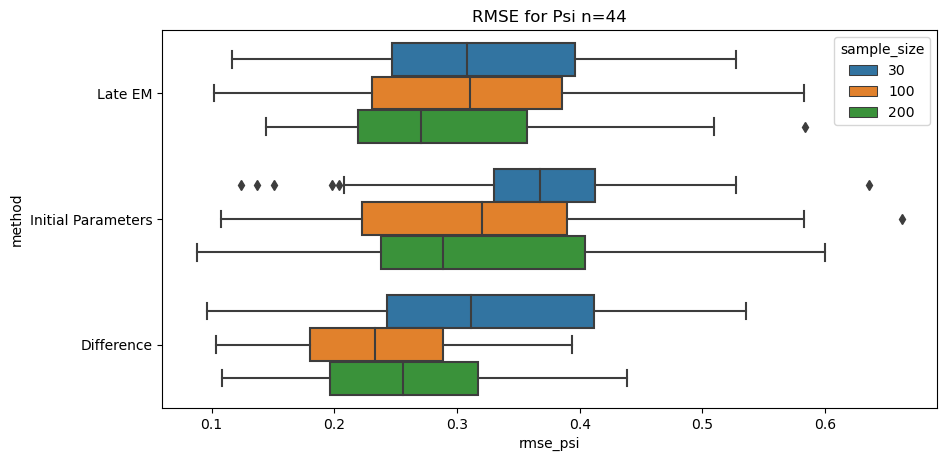

In [21]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [22]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$",
                    methods=["late_em", "initial", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{4}{*}{\textbf{30 }} & \textbf{Initial Parameters} &  0.591 &  0.512 &  0.454 &  0.669 &  0.576 &  0.525 \\
    & \textbf{Late EM} &  0.618 &  0.511 &  0.481 &  0.677 &  0.585 &  0.544 \\
    & \textbf{Pure Competency} &  0.639 &  0.515 &  0.492 &  0.698 &  0.592 &  0.556 \\
    & \textbf{Real Param.} &  0.546 &  0.459 &  0.410 &  0.616 &  0.503 &  0.466 \\
\cline{1-8}
\multirow{4}{*}{\textbf{100}} & \textbf{Initial Parameters} &  0.619 &  0.507 &  0.453 &  0.661 &  0.568 &  0.519 \\
    & \textbf{Late EM} &  0.601 &  0.490 &  0.434 &  0.655 &  0.544 &  0.490 \\
    & \textbf{Pure Competency} & 

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Initial Parameters  0.591  0.512  0.454  0.669  0.576  0.525
    Late EM             0.618  0.511  0.481  0.677  0.585  0.544
    Pure Competency     0.639  0.515  0.492  0.698  0.592  0.556
    Real Param.         0.546  0.459  0.410  0.616  0.503  0.466
100 Initial Parameters  0.619  0.507  0.453  0.661  0.568  0.519
    Late EM             0.601  0.490  0.434  0.655  0.544  0.490
    Pure Competency     0.610  0.493  0.439  0.667  0.563  0.509
    Real Param.         0.578  0.474  0.412  0.623  0.519  0.470
200 Initial Parameters  0.603  0.503  0.445  0.665  0.568  0.515
    Late EM             0.590  0.472  0.422  0.654  0.534  0.479
    Pure Competency     0.597  0.480  0.431  0.667  0.546  0.493
    Real Param.         0.575  0.458  0.412  0.626  0.519  0.468

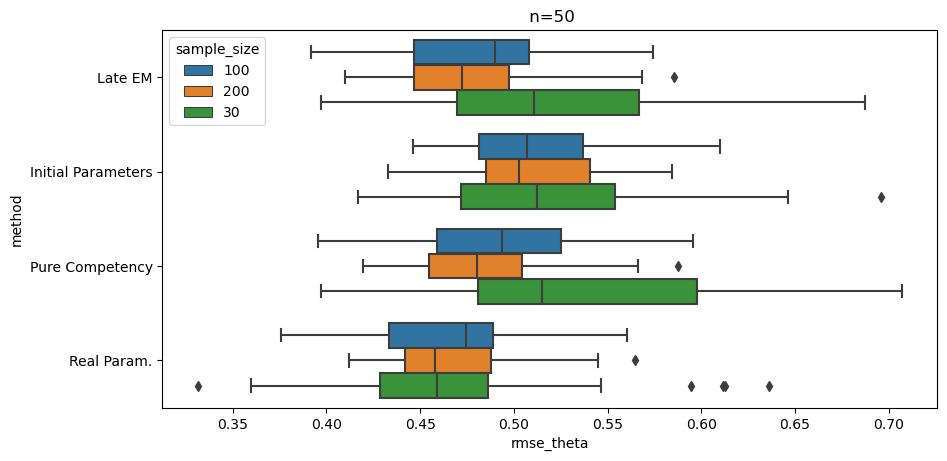

In [23]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters", "pure_competency"], title="")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [24]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation",
                        methods=["late_em", "initial", "difference", "real_early", "real_parameters", "pure_competency"])

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.858 &  0.853 &  0.872 &  0.961 &  0.976 &  0.950 \\
    & \textbf{Initial Parameters} &  0.926 &  1.018 &  1.066 &  0.998 &  1.108 &  1.199 \\
    & \textbf{Late EM} &  0.759 &  0.736 &  0.646 &  0.856 &  0.763 &  0.735 \\
    & \textbf{Pure Competency} &  0.761 &  0.726 &  0.678 &  0.837 &  0.762 &  0.750 \\
    & \textbf{Real Param.} &  0.559 &  0.485 &  0.439 &  0.616 &  0.531 &  0.485 \\
    & \textbf{Real early Param.} &  0.749 &  0.671 &  0.618 &  0.822 &  0.737 &  0.710 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.858  0.853  0.872  0.961  0.976  0.950
    Initial Parameters  0.926  1.018  1.066  0.998  1.108  1.199
    Late EM             0.759  0.736  0.646  0.856  0.763  0.735
    Pure Competency     0.761  0.726  0.678  0.837  0.762  0.750
    Real Param.         0.559  0.485  0.439  0.616  0.531  0.485
    Real early Param.   0.749  0.671  0.618  0.822  0.737  0.710
100 Difference          0.888  0.849  0.849  0.930  0.960  0.946
    Initial Parameters  0.910  1.032  1.043  0.986  1.001  1.202
    Late EM             0.785  0.678  0.614  0.849  0.758  0.709
    Pure Competency     0.769  0.678  0.626  0.824  0.734  0.699
    Real Param.         0.563  0.479  0.437  0.609  0.529  0.482
    Real early Param.   0.735  0.613  0.559  0.821  0.732  0.665
200 Difference          0.850  0.850  0.862  0.943  0.929  0.941
    Initial Parameters  0.889  0.961  1.072  0.987  1.114  1.189
    Late EM             0.761  0.668  0.636  0.857  0.759  0.698
    Pure Competency     0.752  0.672  0.626  0.848  0.755  0.696
    Real Param.         0.567  0.507  0.453  0.613  0.533  0.489
    Real early Param.   0.732  0.619  0.584  0.840  0.720  0.656

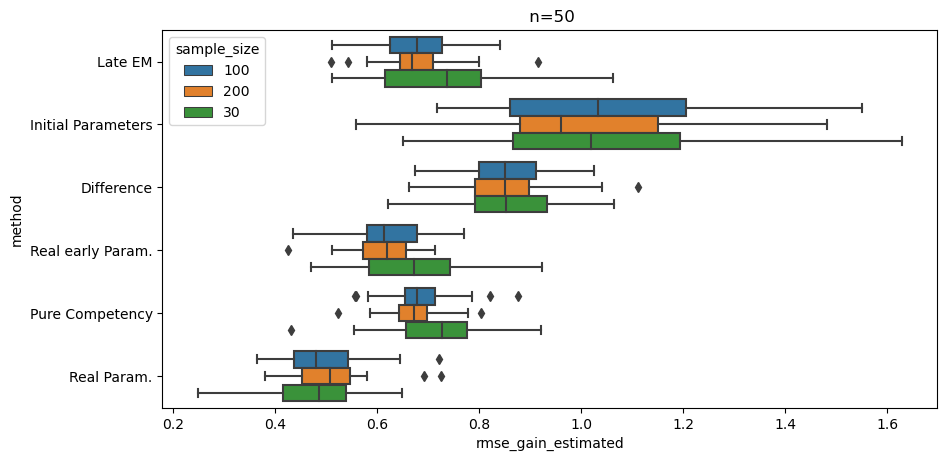

In [25]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [26]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction",
                    methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, $n=47$}
\begin{tabular}{llrrrrrr}
\toprule
    & \textbf{Latent Dimension} & \multicolumn{3}{l}{2} & \multicolumn{3}{l}{3} \\
    & \textbf{Item Dimension} &     10 &     20 &     30 &     10 &     20 &     30 \\
\textbf{N} & \textbf{Method} &        &        &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.938 &  0.925 &  0.883 &  1.035 &  0.992 &  0.983 \\
    & \textbf{Initial Parameters} &  0.968 &  0.984 &  0.935 &  1.025 &  1.036 &  1.034 \\
    & \textbf{Late EM} &  0.957 &  0.986 &  0.947 &  1.027 &  1.058 &  1.054 \\
    & \textbf{Pure Competency} &  0.939 &  0.951 &  0.908 &  1.000 &  0.995 &  1.019 \\
    & \textbf{Real Param.} &  0.808 &  0.812 &  0.792 &  0.856 &  0.840 &  0.872 \\
    & \textbf{Real early Param.} &  0.949 &  0.969 &  0.966 &  1.030 &  1.045 &  1.058 \\
\cline{1-8}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.

Latent Dimension            2                    3              
Item Dimension             10     20     30     10     20     30
N   Method                                                      
30  Difference          0.938  0.925  0.883  1.035  0.992  0.983
    Initial Parameters  0.968  0.984  0.935  1.025  1.036  1.034
    Late EM             0.957  0.986  0.947  1.027  1.058  1.054
    Pure Competency     0.939  0.951  0.908  1.000  0.995  1.019
    Real Param.         0.808  0.812  0.792  0.856  0.840  0.872
    Real early Param.   0.949  0.969  0.966  1.030  1.045  1.058
100 Difference          0.932  0.928  0.880  1.018  1.000  0.957
    Initial Parameters  0.988  1.000  0.979  1.038  1.053  1.058
    Late EM             0.956  0.969  0.959  1.028  1.063  1.045
    Pure Competency     0.943  0.950  0.948  1.010  1.035  1.020
    Real Param.         0.845  0.816  0.822  0.852  0.868  0.843
    Real early Param.   0.970  0.950  0.936  1.039  1.085  1.048
200 Difference          0.918  0.900  0.864  1.044  0.992  0.937
    Initial Parameters  0.965  0.978  0.968  1.066  1.045  1.069
    Late EM             0.955  0.981  0.962  1.061  1.061  1.038
    Pure Competency     0.923  0.955  0.928  1.052  1.023  1.021
    Real Param.         0.785  0.824  0.809  0.882  0.854  0.829
    Real early Param.   0.964  0.953  0.941  1.076  1.073  1.061

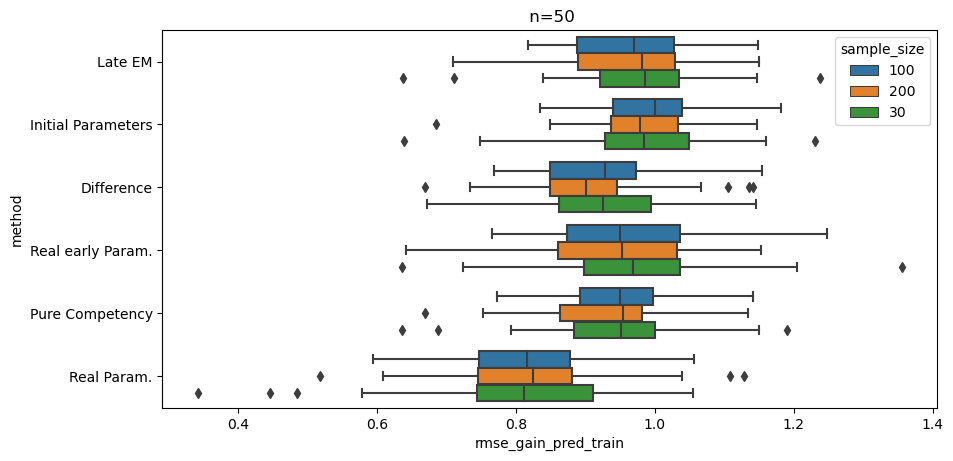

In [27]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

## CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

### Read in and preprocess data

In [28]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [29]:
semester = 'F19'
# BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
BASE_PATH = os.path.join('C:/Users/Gerha/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [30]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [31]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [32]:
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [34]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]
# Ensure Identification
late_Q[2,1] = False

In [35]:
late_Q

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True]])

### Fit Model

In [73]:
import random
random.seed(100)
np.random.seed(100)

In [74]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.4027]
 [0.4027 1.    ]]
Step: 2: current parameter_diff: 8.206138301834038, current marginal loglikelihood: -5613.803952800157
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.3486]
 [0.3486 1.    ]]
Step: 3: current parameter_diff: 4.377151227660264, current marginal loglikelihood: -5595.398596762748
EM Iteration 4
Current Monte Carlo Sample size: 349
[[0.9999 0.3239]
 [0.3239 1.    ]]
Step: 4: current parameter_diff: 1.3175327391583271, current marginal loglikelihood: -5590.271398404762
EM Iteration 5
Current Monte Carlo Sample size: 376
[[1.     0.2897]
 [0.2897 1.    ]]
Step: 5: current parameter_diff: 2.2093959839237955, current marginal loglikelihood: -5587.203587338136
EM Iteration 6
Current Monte Carlo Sample size: 406
[[1.     0.2894]
 [0.2894 1.    ]]
Step: 6: current parameter_diff: 1.5644215991114212, current marginal loglikelihood: -5576.914421972816
EM Iteration 7
Current Monte Carlo Sample size: 438
[[1.     0.2889]
 [0.2889 1.    ]]
Step: 7: current parameter_diff: 0.5395765560027932, current marginal loglikelihood: -5581.662270963657
EM Iteration 8
Current Monte Carlo Sample size: 438
[[0.9999 

In [75]:
p_early = np.mean(U, axis=1)
p_late = np.mean(V, axis=1)
# Correct numerical problems with the inverse logistic function
p_early[p_early == 0] = np.min(p_early[p_early != 0])
p_early[p_early == 1] = np.max(p_early[p_early != 1])
p_late[p_late == 0] = np.min(p_late[p_late != 0])
p_late[p_late == 1] = np.max(p_late[p_late != 1])
# get logits
logit_early = np.log(np.divide(p_early, 1 -
                                p_early))
logit_late = np.log(np.divide(p_late, 1 -
                                p_late))
var_logit_early = np.var(logit_early)
var_logit_late = np.var(logit_late)

#
print("Early logit variance: {0}".format(var_logit_early))
print("Late logit variance: {0}".format(var_logit_late))
print("Approximate convolution variance: {0}".format(var_logit_late/var_logit_early))

Early logit variance: 1.2907867467786318
Late logit variance: 1.790658381505874
Approximate convolution variance: 1.3872612079220314


In [76]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.zeros(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    convolution_variance=np.ones(2)*var_logit_late/var_logit_early,
    sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model, convolution_factor=20, gamma=1.5)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.005, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[1.     0.2636 0.1248 0.0672]
 [0.2636 0.9999 0.063  0.1308]
 [0.1248 0.063  0.3509 0.0942]
 [0.0672 0.1308 0.0942 0.3366]]
Step: 2: current parameter_diff: 11.160060041236262, current marginal loglikelihood: -4261.368026108443
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.2636 0.1351 0.0659]
 [0.2636 0.9999 0.0672 0.1396]
 [0.1351 0.0672 0.3588 0.0922]
 [0.0659 0.1396 0.0922 0.3438]]
Step: 3: current parameter_diff: 6.867141626952582, current marginal loglikelihood: -4251.797768301702
EM Iteration 4


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[1.     0.2636 0.1337 0.0697]
 [0.2636 0.9999 0.0651 0.1386]
 [0.1337 0.0651 0.3513 0.0938]
 [0.0697 0.1386 0.0938 0.3425]]
Step: 4: current parameter_diff: 1.9959383561943156, current marginal loglikelihood: -4243.964200170161
EM Iteration 5


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[1.     0.2636 0.1332 0.0685]
 [0.2636 0.9999 0.0661 0.138 ]
 [0.1332 0.0661 0.3543 0.0921]
 [0.0685 0.138  0.0921 0.3421]]
Step: 5: current parameter_diff: 2.9732849684505007, current marginal loglikelihood: -4233.91027267949


### Postprocess

#### Item Parameters

In [77]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [131]:
def rel_test_difficulty(A, delta):
    rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)
    rel_item_difficulty[np.isinf(rel_item_difficulty)] = np.nan
    rel_test_difficulty = np.nanmedian(rel_item_difficulty, axis=0)
    return(rel_test_difficulty)


def shift_table(s_hat, A, delta, early_reldiff):
    quantiles = np.arange(0, 0.5, 0.01)
    # mu_logic = []
    # mu_iter = []
    perc_pos_logic =[]
    perc_pos_iter = []
    logic_reldiff = []
    iter_reldiff = []
    for quantile in quantiles:
        shift = -1*np.quantile(s_hat, q=quantile, axis=0)
        delta_shift = late_delta - np.dot(late_A, shift)
        s_shift = s_hat + shift
        perc_positive = np.divide(np.sum(s_shift >= 0, axis=0), np.sum(s_shift == s_shift, axis=0))
        perc_pos_logic.append(perc_positive[0])
        perc_pos_iter.append(perc_positive[1])
        # mu_shift = np.mean(s_shift, axis=0)
        # mu_logic.append(mu_shift[0])
        #mu_iter.append(mu_shift[1])
        rel_test_diff = rel_test_difficulty(A=A, delta=delta_shift)
        logic_reldiff.append(rel_test_diff[0])
        iter_reldiff.append(rel_test_diff[1])
# Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(9)
    f.tight_layout(pad=1.5)
    #f.suptitle("Share of students with Competency \n Gain vs. Relative Test Difficulty", fontsize=14, y=1.05)
    ax1.plot(perc_pos_logic, logic_reldiff)
    ax1.plot(perc_pos_logic, [early_reldiff[0] for i in range(0, len(perc_pos_iter))])
    ax1.set_title("Logic Competency")
    ax2.plot(perc_pos_iter, iter_reldiff)
    ax2.plot(perc_pos_iter, [early_reldiff[1] for i in range(0, len(perc_pos_iter))])
    ax2.set_title("Iteration Competency")
    ax1.set_ylabel("Relative Difficulty", fontsize=12)
    ax1.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    ax2.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    plt.legend(["Late Difficulty", "Early Difficulty"], fontsize=11)
    #f.title("Share of students with Competency \n Gain vs. Relative Test Difficulty")

C:\Users\Gerha\AppData\Local\Temp\ipykernel_11312\1637136352.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


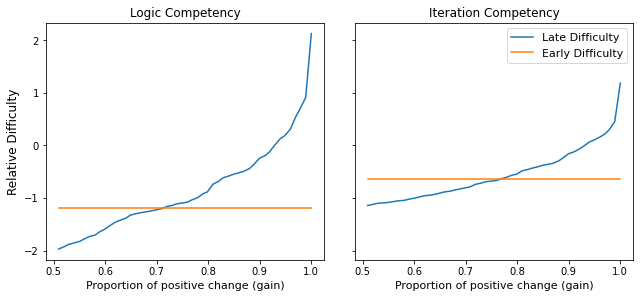

In [132]:
early_reldiff = rel_test_difficulty(A=early_A, delta=early_delta)
shift_table(s_hat=s_hat, A=late_A, delta=late_delta, early_reldiff=early_reldiff)
plt.savefig("results/plots/csedm_reldiff_vs_shift", dpi=250)

In [80]:
rel_test_difficulty(A=early_A, delta=early_delta)

C:\Users\Gerha\AppData\Local\Temp\ipykernel_11312\1158090350.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


array([-1.19815747, -0.6331392 ])

In [134]:
shift = np.zeros(2)
#Logic shift
shift[0] = -1*np.quantile(s_hat[:,0], q=0.15, axis=0)
#Iteration shift
shift[1] = -1*np.quantile(s_hat[:,1], q=0.05, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [135]:
#Check shift results
np.divide(np.sum(s_hat_shift >= 0, axis=0), np.sum(s_hat_shift == s_hat_shift, axis=0))

array([0.85013624, 0.94822888])

#### Fit difference Model

In [85]:
# Fit late difference model
late_difference_model = mirt_2pl(latent_dimension=2, item_dimension=V.shape[1], Q=late_Q)
late_difference_model.initialize_from_responses(response_data=V)
e_step_diff = e_step_ga_mml(model=late_difference_model)
m_step_diff = m_step_ga_mml(
    late_difference_model, sigma_constraint="early_constraint")
em_diff = em_algo(e_step=e_step_diff, m_step=m_step_diff, model=late_difference_model)


start_time = time.time()
em_diff.fit([V.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)

estimated_diff_item_parameters = em_diff.model.item_parameters
estimated_diff_person_parameters = em_diff.model.person_parameters

# Estimate early parameters with standard-procedure

# Shift Discriminations and Covariance accoring to real variance
conv_sigma = late_difference_model.person_parameters["covariance"]
conv_A = late_difference_model.item_parameters["discrimination_matrix"]
real_conv_sigma_var = var_logit_late/var_logit_early*np.ones(2)
conv_sd_vector = np.sqrt(real_conv_sigma_var)
conv_sd_matrix = np.diag(conv_sd_vector)
conv_sigma_scaled = np.round(np.dot(
    np.dot(conv_sd_matrix, conv_sigma), conv_sd_matrix), 5)
conv_A_scaled = np.dot(conv_A, np.linalg.inv(conv_sd_matrix).transpose())
scaled_parameters = {"person_parameters": {"covariance": conv_sigma_scaled},
                        "item_parameters": {"discrimination_matrix": conv_A_scaled}}
late_difference_model.set_parameters(scaled_parameters)


#Predict 
late_theta_hat = late_difference_model.predict_competency(
    V, strict_variance=False) + shift
# Double late theta because var(late_theta) = var(early_theta + gain) = var(early_theta) + var(gain) - 2*cov(early_theta, gain)
s_hat_diff = late_theta_hat - theta_hat

EM Iteration 2


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[0.9999 0.4967]
 [0.4967 1.    ]]
Step: 2: current parameter_diff: 6.431710228256767, current marginal loglikelihood: -3470.334968764041
EM Iteration 3


c:\Users\Gerha\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324


KeyboardInterrupt: 

In [55]:
np.mean(s_hat_diff, axis=0)

array([0.25031249, 0.95644352])

In [56]:
pd.DataFrame(np.concatenate((theta_hat, s_hat), axis=1)).cov()

,0,1,2,3
0,0.663823,0.258745,-0.011701,-0.060073
1,0.258745,0.631272,0.015110,-0.001835
2,-0.011701,0.015110,0.131428,0.143010
3,-0.060073,-0.001835,0.143010,0.258920


In [57]:
conv_A_scaled

array([[0.        , 0.28404248],
       [1.42965521, 0.29420328],
       [1.15350163, 0.        ],
       [1.60502226, 0.94795313],
       [1.42629083, 0.26123654],
       [0.6612715 , 0.44370995],
       [0.96809642, 0.51597438],
       [0.5006261 , 1.02823122],
       [1.33152079, 1.25278255],
       [0.34442147, 0.95588689],
       [1.10463834, 0.82424051],
       [0.38710207, 1.75585048],
       [0.26751935, 1.67573407],
       [0.4887894 , 0.89491133],
       [0.        , 1.16229546],
       [0.26432815, 1.95916286],
       [0.53273588, 1.62045724],
       [0.20048132, 1.42337082],
       [0.        , 1.92445104],
       [0.        , 1.73402049]])

In [58]:
estimated_diff_parameters["item_parameters"]["discrimination_matrix"] = conv_A_scaled
late_delta = late_estimated_parameters["item_parameters"]["intercept_vector"]
translated_delta = late_delta - \
    np.dot(late_estimated_parameters["item_parameters"]
            ["discrimination_matrix"], np.ones(D))
late_estimated_parameters["item_parameters"]["intercept_vector"] = translated_delta
sigma_psi = pd.DataFrame(np.concatenate(
    (early_theta_hat, s_hat), axis=1)).cov().to_numpy()
late_estimated_parameters["person_parameters"]["covariance"] = sigma_psi

######################
item_dimension = parameter_dict["item_dimension"]
actual_late_model = mirt_2pl_gain(item_dimension=item_dimension, latent_dimension=D,
                                    mu=gain_mean,
                                    early_sigma=early_estimated_parameters["person_parameters"]["covariance"],
                                    Q=parameter_dict["real_late_parameters"]["item_parameters"]["q_matrix"])

NameError: name 'estimated_diff_parameters' is not defined

## Report Item Parameters

In [136]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [143]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.884 &     0.000 &    1.613 \\
\textbf{1 } &   1.0 &       0.0 &  1.209 &     0.000 &    1.344 \\
\textbf{2 } &   1.0 &       0.0 &  0.917 &     0.000 &    1.308 \\
\textbf{3 } &   1.0 &       0.0 &  0.722 &     0.000 &    1.292 \\
\textbf{4 } &   1.0 &       0.0 &  1.188 &     0.000 &    1.290 \\
\textbf{5 } &   1.0 &       0.0 &  1.439 &     0.000 &    1.445 \\
\textbf{6 } &   1.0 &       0.0 &  1.013 &     0.000 &    1.162 \\
\textbf{7 } &   1.0 &       0.0 &  0.865 &     0.000 &    1.284 \\
\textbf{8 } &   1.0 &       0.0 &  1.016 &     0.000 &    1.148 \\
\textbf{9 } &   1.0 &       0.0 &  1.375 &     0.000 &    1.241 \\
\textbf{10} &   1.0 &       0.0 &  1.182 &     0.00

Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.884     0.000    1.613
1             1.0       0.0  1.209     0.000    1.344
2             1.0       0.0  0.917     0.000    1.308
3             1.0       0.0  0.722     0.000    1.292
4             1.0       0.0  1.188     0.000    1.290
5             1.0       0.0  1.439     0.000    1.445
6             1.0       0.0  1.013     0.000    1.162
7             1.0       0.0  0.865     0.000    1.284
8             1.0       0.0  1.016     0.000    1.148
9             1.0       0.0  1.375     0.000    1.241
10            1.0       0.0  1.182     0.000    1.416
11            1.0       0.0  1.229     0.000    1.588
12            1.0       0.0  1.140     0.000    1.518
13            1.0       0.0  1.298     0.000    1.398
14            1.0       0.0  1.102     0.000    1.142
15            1.0       0.0  1.239     0.000    0.759
16            1.0       0.0  1.209     0.000    1.201
17            1.0       0.0  1.000     0.000    1.195
18            1.0       1.0  1.201     0.669    0.095
19            1.0       0.0  0.887     0.000    0.596
20            0.0       1.0  0.000     2.438    1.559
21            1.0       1.0  0.073     2.374    1.214
22            1.0       1.0  0.322     1.633    1.075
23            1.0       1.0  0.427     1.627    1.020
24            1.0       1.0  0.968     1.214    1.365
25            1.0       0.0  0.875     0.000    1.066
26            1.0       1.0  0.577     1.105    0.571
27            1.0       1.0  0.869     1.295    1.236
28            1.0       1.0  0.822     1.017    0.991
29            1.0       1.0  0.642     1.828    1.026

In [144]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.565 &    0.874 \\
\textbf{1 } &   1.0 &       1.0 &  0.921 &     0.907 &    0.246 \\
\textbf{2 } &   1.0 &       0.0 &  1.297 &     0.000 &    1.334 \\
\textbf{3 } &   1.0 &       1.0 &  0.965 &     1.349 &   -0.182 \\
\textbf{4 } &   1.0 &       1.0 &  1.000 &     0.764 &    0.134 \\
\textbf{5 } &   1.0 &       1.0 &  0.600 &     0.822 &    0.146 \\
\textbf{6 } &   1.0 &       1.0 &  0.960 &     0.756 &    0.007 \\
\textbf{7 } &   1.0 &       1.0 &  0.127 &     1.423 &    0.009 \\
\textbf{8 } &   1.0 &       1.0 &  0.996 &     2.056 &   -0.754 \\
\textbf{9 } &   1.0 &       1.0 &  0.381 &     1.421 &   -0.790 \\
\textbf{10} &   1.0 &       1.0 &  0.995 &     1.238

Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.565    0.874
1             1.0       1.0  0.921     0.907    0.246
2             1.0       0.0  1.297     0.000    1.334
3             1.0       1.0  0.965     1.349   -0.182
4             1.0       1.0  1.000     0.764    0.134
5             1.0       1.0  0.600     0.822    0.146
6             1.0       1.0  0.960     0.756    0.007
7             1.0       1.0  0.127     1.423    0.009
8             1.0       1.0  0.996     2.056   -0.754
9             1.0       1.0  0.381     1.421   -0.790
10            1.0       1.0  0.995     1.238    0.020
11            1.0       1.0  0.678     2.132    0.072
12            1.0       1.0  0.447     1.643   -0.414
13            1.0       1.0  0.619     1.252    0.235
14            0.0       1.0  0.000     1.071    0.968
15            1.0       1.0  0.177     2.060   -0.171
16            1.0       1.0  0.464     1.658   -0.748
17            1.0       1.0  0.581     1.074    0.019
18            0.0       1.0  0.000     1.846   -0.197
19            0.0       1.0  0.000     1.493    0.259

(array([[  4.,  16.,  68., 119., 144.,  15.,   1.,   0.,   0.,   0.],
        [  1.,   3.,  30.,  45.,  69.,  96.,  98.,  21.,   1.,   3.]]),
 array([-0.8881526 , -0.54133085, -0.1945091 ,  0.15231265,  0.49913439,
         0.84595614,  1.19277789,  1.53959964,  1.88642138,  2.23324313,
         2.58006488]),
 <a list of 2 BarContainer objects>)

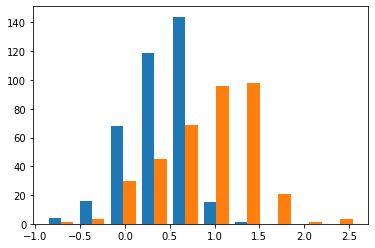

In [139]:
plt.hist(s_hat_shift)

#### Person Parameters

In [140]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [141]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [142]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.264 &           0.133 &     0.068 &  0.000 \\
                & \textbf{Iteration} &            0.264 &     1.000 &           0.066 &     0.138 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &            0.133 &     0.066 &           0.354 &     0.092 &  0.368 \\
                & \textbf{Iteration} &            0.068 &     0.138 &           0.092 &     0.342 &  0.893 \\
\bottomrule
\end{tabular}
\end{table}



Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.264           0.133   
                 Iteration              0.264     1.000           0.066   
Competence Gain  Logic                  0.133     0.066           0.354   
                 Iteration              0.068     0.138           0.092   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic           0.068  0.000  
                 Iteration       0.138  0.000  
Competence Gain  Logic           0.092  0.368  
                 Iteration       0.342  0.893

#### Gain Visualization

In [145]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [146]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [147]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.93,-0.22,0.42,1.01,-0.51,0.80
0.50,-0.18,-0.06,0.35,0.84,0.16,0.78
0.75,0.35,-0.00,0.38,0.86,0.73,0.86
1.00,1.11,0.42,0.44,0.94,1.55,1.36


In [148]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [149]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

## Test Set prediction

In [46]:
TEST_PATH = os.path.join("C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

#test_subject_df = make_subject_df(early_test)
#test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")